In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi

Mon Aug 23 05:13:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
path = '/content/drive/MyDrive/DRIVE project/Pytorch1'
import sys
sys.path.append(path)

In [5]:
from os import write
from torch import optim
from model1 import UNet
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
from loss import *
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

#torch.autograd.detect_anomaly(True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


#### Path and image size declaration

In [6]:
PATH = '/content/drive/MyDrive/DRIVE project/performances record1/balanced BCE1/unet_45epoch.pt'
IMAGE_HEIGHT=512
IMAGE_WIDTH=512

#### He normal initialization of the training weights for faster convergence.

In [7]:
def weight_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))
        nn.init.zeros_(m.bias)

#### Class to load the image dataset and access its items

In [8]:
class ImgDataset(Dataset):

    def __init__(self,transform=None):
        self.transform=transform
        x = np.load('/content/drive/MyDrive/DRIVE project/dataset/train_image_256.npy')
        y = np.load('/content/drive/MyDrive/DRIVE project/dataset/train_mask_256.npy')
        
        x=x/255
        y=y/255

        
        self.n_samples = x.shape[0]
        """
        self.X_data = torch.from_numpy(x).type(torch.FloatTensor)
        self.Y_data = torch.from_numpy(y).type(torch.FloatTensor)
        """
        self.X_data=x
        self.Y_data=y

    def __getitem__(self, index):
        image,mask = self.X_data[index], self.Y_data[index]
        
        if self.transform:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

    def __len__(self):
        return self.n_samples

In [9]:
## This tranform operation will be used when running the dataloader
transform0 = A.Compose([
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(mean=(0.0),std=(1.0),max_pixel_value=255.0,),ToTensorV2()])


In [10]:
dataset = ImgDataset(transform=transform0)
l = len(dataset)
tr_size = int(l*0.8)

val_size = (l-tr_size)


train_set, val_set = torch.utils.data.random_split(
    dataset, [tr_size, val_size])

train_loader = DataLoader(dataset=train_set,
                          batch_size=8,
                          shuffle=True,
                          num_workers=0, drop_last=True)


val_loader = DataLoader(dataset=val_set,
                        batch_size=8,
                        shuffle=True,
                        drop_last=True,
                        num_workers=0)

In [11]:
## Initiialize model, and weights 
model = UNet().to(device)
model.apply(weight_init)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
optimizer=torch.optim.Adam(model.parameters(), lr=0.001)

print(model)

UNet(
  (conv1_1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.2, inplace=False)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.35, inplace=False)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.25, inplace=False)
  (conv4_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_2): Conv2d(512, 512, ke

In [12]:
epochs = 50
e_loss = []
e_val_loss = []
e_val_score=[]
n_iter = 0
n_epochs_stop = 5
epochs_no_improve = 0
early_stop = True
min_val_loss = np.Inf
e=0

In [13]:
writer =SummaryWriter()
### Code to train the models
for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)

    running_loss = 0.0
    running_score = 0.0
    with tqdm(train_loader, unit="batch") as tepoch:
        for (images, masks) in tepoch:
            tepoch.set_description(f"Epoch {epoch+1}")

            images, masks = images.to(device), masks.to(device)
            
            #images = images.permute(0, 3, 1, 2)
            #masks = masks.permute(0, 3, 1, 2)
            
            output = model(images)
            
            loss = balanced_bce(input=output, target=masks)
            optimizer.zero_grad()
            loss.backward()

            optimizer.step()

            running_loss += loss.item()
            tepoch.set_postfix(loss=loss.item()) 
            writer.add_scalar('Training Loss',loss,global_step=e)

            
    epoch_loss = running_loss / len(train_loader)
    print(f"Train - Loss: {epoch_loss:.4f}")
    e_loss.append(epoch_loss)
    e+=1

    with torch.no_grad():
        val_loss = 0
        val_score = 0
        for batch_idx, (images_val, masks_val) in enumerate(val_loader):
            images_val, masks_val = images_val.to(device), masks_val.to(device)
            
            #images_val = images_val.permute(0, 3, 1, 2)
            #masks_val = masks_val.permute(0, 3, 1, 2)
            
            output = model(images_val)
            
            loss = balanced_bce(input=output, target=masks_val)

            score=dice_coeff(input=output, target=masks_val)

            val_loss += loss.item()
            
            val_score += score.item()
        

        val_epoch_loss = val_loss / len(val_loader)
        print(f"Val Loss: {val_epoch_loss:.4f}")
        e_val_loss.append(val_epoch_loss)
        
        val_epoch_score=val_score/len(val_loader)
        print(f"Val Score(Dice Coeff): {val_epoch_score:.8f}")
        e_val_score.append(val_epoch_score)

        if val_epoch_loss < min_val_loss:
            print('val_loss<min_val_loss', min_val_loss)
            torch.save(model.state_dict(), PATH)
            print('Model Saved at:', str(PATH))
            epochs_no_improve = 0
            min_val_loss = val_epoch_loss

        else:
            epochs_no_improve += 1
        n_iter += 1
        if epoch > 5 and epochs_no_improve == n_epochs_stop:
            print('Early stopping!')
            early_stop = True
            break
        else:
            continue
  

Epoch 1/50
----------


  0%|          | 0/25 [00:00<?, ?batch/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train - Loss: 0.3637
Val Loss: 0.3303
Val Score(Dice Coeff): 0.26146377
val_loss<min_val_loss inf
Model Saved at: /content/drive/MyDrive/DRIVE project/performances record1/balanced BCE1/unet_45epoch.pt
Epoch 2/50
----------


  0%|          | 0/25 [00:00<?, ?batch/s]

Train - Loss: 0.3304
Val Loss: 0.3266
Val Score(Dice Coeff): 0.23525477
val_loss<min_val_loss 0.33030811448891956
Model Saved at: /content/drive/MyDrive/DRIVE project/performances record1/balanced BCE1/unet_45epoch.pt
Epoch 3/50
----------


  0%|          | 0/25 [00:00<?, ?batch/s]

Train - Loss: 0.3301
Val Loss: 0.3292
Val Score(Dice Coeff): 0.24080885
Epoch 4/50
----------


  0%|          | 0/25 [00:00<?, ?batch/s]

Train - Loss: 0.3281
Val Loss: 0.3280
Val Score(Dice Coeff): 0.23432734
Epoch 5/50
----------


  0%|          | 0/25 [00:00<?, ?batch/s]

Train - Loss: 0.3279
Val Loss: 0.3312
Val Score(Dice Coeff): 0.20857568
Epoch 6/50
----------


  0%|          | 0/25 [00:00<?, ?batch/s]

Train - Loss: 0.3411
Val Loss: 0.3333
Val Score(Dice Coeff): 0.20195484
Epoch 7/50
----------


  0%|          | 0/25 [00:00<?, ?batch/s]

Train - Loss: 0.3293
Val Loss: 0.3271
Val Score(Dice Coeff): 0.22866670
Early stopping!


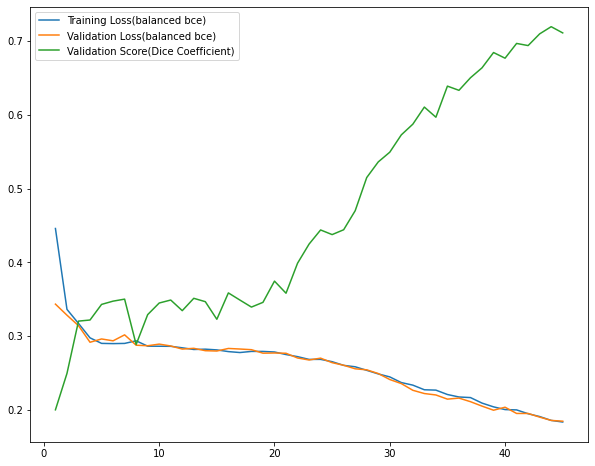

In [14]:
plt.figure(figsize = (10,8))
plt.plot(1+np.arange(e), e_loss, label='Training Loss(balanced bce)')
plt.plot(1+np.arange(e), e_val_loss,label='Validation Loss(balanced bce)')
plt.plot(1+np.arange(e), e_val_score, label='Validation Score(Dice Coefficient)')
plt.legend()
plt.savefig('/content/drive/MyDrive/DRIVE project/performances record1/balanced BCE1/plot.png')
plt.show()